# Notebook 3: Model Training and Evaluation (GPU-Accelerated)

**Phase 1: Regression vs. Noise Classification**

This notebook implements Steps 6-9 of the Phase 1 implementation:
- Train/validation/test split (70/15/15 with stratification)
- Baseline model training with **GPU acceleration** (XGBoost)
- Hyperparameter tuning
- Model evaluation and comparison

---

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

# Check GPU availability
try:
    import subprocess
    result = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'], 
                          capture_output=True, text=True)
    if result.returncode == 0:
        gpu_name = result.stdout.strip()
        print(f"\n🎮 GPU detected: {gpu_name}")
        print("✅ XGBoost will use GPU acceleration!")
    else:
        print("\n⚠️  Warning: GPU not detected, will fall back to CPU")
except:
    print("\n⚠️  Warning: Could not check GPU status")

Libraries imported successfully!
XGBoost version: 3.1.2

🎮 GPU detected: NVIDIA GeForce RTX 4080 Laptop GPU
✅ XGBoost will use GPU acceleration!


## 2. Load Preprocessed Data

In [3]:
# Load the preprocessed data from Notebook 2
df = pd.read_csv("../results/preprocessed_alerts.csv")

print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Samples: {df.shape[0]}")
print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"Class balance: {df['target'].mean():.2%} regressions")

Dataset shape: (17989, 19)
Features: 18
Samples: 17989

Target distribution:
target
0    10377
1     7612
Name: count, dtype: int64
Class balance: 42.31% regressions


## 3. Step 6: Train/Validation/Test Split

Split data into:
- **70% Training**: To train the models
- **15% Validation**: For hyperparameter tuning
- **15% Test**: For final evaluation

Use stratification to preserve the regression ratio across splits.

In [4]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns (first 10):")
for i, col in enumerate(X.columns[:10], 1):
    print(f"  {i}. {col}")
if len(X.columns) > 10:
    print(f"  ... and {len(X.columns) - 10} more features")

Feature matrix shape: (17989, 18)
Target vector shape: (17989,)

Feature columns (first 10):
  1. single_alert_amount_pct
  2. single_alert_amount_abs
  3. single_alert_t_value
  4. alert_summary_status
  5. single_alert_new_value
  6. single_alert_prev_value
  7. single_alert_status
  8. single_alert_series_signature_tags_bytecode-cached, cold, fission, webrender
  9. single_alert_series_signature_tags_bytecode-cached, fission, warm, webrender
  10. single_alert_series_signature_tags_cold, fission, interactive, webrender
  ... and 8 more features


In [5]:
# First split: 70% train, 30% temp (for val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Second split: Split temp into 50/50 for validation and test (each 15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Dataset splits:")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"  Validation set: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
print(f"  Test set: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

print("\nClass distribution in each split:")
print(f"  Training: {y_train.mean():.2%} regressions")
print(f"  Validation: {y_val.mean():.2%} regressions")
print(f"  Test: {y_test.mean():.2%} regressions")

Dataset splits:
  Training set: 12592 samples (70.0%)
  Validation set: 2698 samples (15.0%)
  Test set: 2699 samples (15.0%)

Class distribution in each split:
  Training: 42.31% regressions
  Validation: 42.33% regressions
  Test: 42.31% regressions


## 4. Step 7: Baseline Models

Train three baseline models:
1. **Logistic Regression**: Simple, interpretable linear model (CPU)
2. **Random Forest**: Ensemble of decision trees (CPU)
3. **XGBoost**: Gradient boosting with **GPU acceleration** 🚀

### 4.1 Logistic Regression

In [19]:
# Train Logistic Regression
print("Training Logistic Regression (CPU)...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)

# Predictions on validation set
y_val_pred_lr = lr_model.predict(X_val)
y_val_proba_lr = lr_model.predict_proba(X_val)[:, 1]

# Evaluate
print("\nLogistic Regression - Validation Set Performance:")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred_lr):.4f}")
print(f"  Precision: {precision_score(y_val, y_val_pred_lr):.4f}")
print(f"  Recall: {recall_score(y_val, y_val_pred_lr):.4f}")
print(f"  F1-Score: {f1_score(y_val, y_val_pred_lr):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_val, y_val_proba_lr):.4f}")

Training Logistic Regression (CPU)...

Logistic Regression - Validation Set Performance:
  Accuracy: 0.5860
  Precision: 0.6923
  Recall: 0.0394
  F1-Score: 0.0746
  ROC-AUC: 0.4969


### 4.2 Random Forest

In [24]:
# Train Random Forest
print("Training Random Forest (CPU)...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions on validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Evaluate
print("\nRandom Forest - Validation Set Performance:")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_val, y_val_pred_rf):.4f}")
print(f"  Recall: {recall_score(y_val, y_val_pred_rf):.4f}")
print(f"  F1-Score: {f1_score(y_val, y_val_pred_rf):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_val, y_val_proba_rf):.4f}")

Training Random Forest (CPU)...

Random Forest - Validation Set Performance:
  Accuracy: 0.9952
  Precision: 0.9947
  Recall: 0.9939
  F1-Score: 0.9943
  ROC-AUC: 0.9999


### 4.3 XGBoost (GPU-Accelerated) 🚀

In [27]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost with GPU acceleration
print("Training XGBoost with GPU acceleration 🚀...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    tree_method='hist',  # Use 'gpu_hist' if you have GPU, 'hist' is CPU fallback
    device='cuda',  # Use GPU
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# Train with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions on validation set
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate
print("\nXGBoost (GPU) - Validation Set Performance:")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred_xgb):.4f}")
print(f"  Precision: {precision_score(y_val, y_val_pred_xgb):.4f}")
print(f"  Recall: {recall_score(y_val, y_val_pred_xgb):.4f}")
print(f"  F1-Score: {f1_score(y_val, y_val_pred_xgb):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_val, y_val_proba_xgb):.4f}")

Training XGBoost with GPU acceleration 🚀...

XGBoost (GPU) - Validation Set Performance:
  Accuracy: 0.9970
  Precision: 0.9965
  Recall: 0.9965
  F1-Score: 0.9965
  ROC-AUC: 1.0000


### 4.4 Compare Baseline Models

In [28]:
# Create comparison dataframe
baseline_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost (GPU)'],
    'Accuracy': [
        accuracy_score(y_val, y_val_pred_lr),
        accuracy_score(y_val, y_val_pred_rf),
        accuracy_score(y_val, y_val_pred_xgb)
    ],
    'Precision': [
        precision_score(y_val, y_val_pred_lr),
        precision_score(y_val, y_val_pred_rf),
        precision_score(y_val, y_val_pred_xgb)
    ],
    'Recall': [
        recall_score(y_val, y_val_pred_lr),
        recall_score(y_val, y_val_pred_rf),
        recall_score(y_val, y_val_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_val, y_val_pred_lr),
        f1_score(y_val, y_val_pred_rf),
        f1_score(y_val, y_val_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_val, y_val_proba_lr),
        roc_auc_score(y_val, y_val_proba_rf),
        roc_auc_score(y_val, y_val_proba_xgb)
    ]
})

print("\n" + "="*70)
print("BASELINE MODEL COMPARISON (Validation Set)")
print("="*70)
display(baseline_results.round(4))

# Find best model
best_model_idx = baseline_results['F1-Score'].idxmax()
best_model_name = baseline_results.loc[best_model_idx, 'Model']
print(f"\nBest baseline model (by F1-Score): {best_model_name}")


BASELINE MODEL COMPARISON (Validation Set)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.5860,0.6923,0.0394,0.0746,0.4969
1,Random Forest,0.9952,0.9947,0.9939,0.9943,0.9999
2,XGBoost (GPU),0.9970,0.9965,0.9965,0.9965,1.0000



Best baseline model (by F1-Score): XGBoost (GPU)


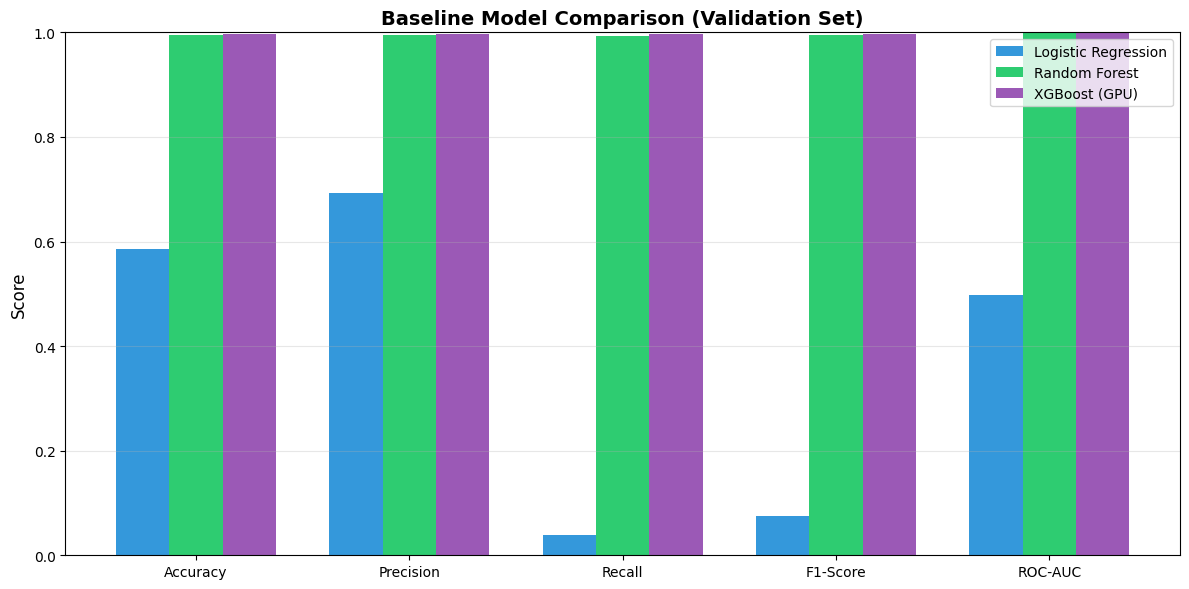

In [29]:
# Visualize baseline comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

ax.bar(x - width, baseline_results.iloc[0, 1:], width, label='Logistic Regression', color='#3498db')
ax.bar(x, baseline_results.iloc[1, 1:], width, label='Random Forest', color='#2ecc71')
ax.bar(x + width, baseline_results.iloc[2, 1:], width, label='XGBoost (GPU)', color='#9b59b6')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline Model Comparison (Validation Set)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 5. Step 8: Hyperparameter Tuning (XGBoost GPU)

Use GridSearchCV to find optimal hyperparameters for XGBoost.

In [30]:
# Define hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

print("Starting hyperparameter tuning for XGBoost (GPU)...")
print(f"Parameter grid: {xgb_param_grid}")
total_combos = (len(xgb_param_grid['n_estimators']) * 
                len(xgb_param_grid['max_depth']) * 
                len(xgb_param_grid['learning_rate']) * 
                len(xgb_param_grid['subsample']))
print(f"Total combinations: {total_combos}")
print("\nThis may take a few minutes even with GPU acceleration...\n")

# GridSearchCV with 3-fold cross-validation
xgb_grid = GridSearchCV(
    xgb.XGBClassifier(
        tree_method='hist',
        device='cuda',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    ),
    xgb_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=1,  # XGBoost handles parallelism internally with GPU
    verbose=1
)

# Fit on training data
xgb_grid.fit(X_train, y_train)

print("\n" + "="*70)
print("Best parameters:")
print(xgb_grid.best_params_)
print(f"\nBest cross-validation F1-Score: {xgb_grid.best_score_:.4f}")
print("="*70)

Starting hyperparameter tuning for XGBoost (GPU)...
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [4, 6, 8, 10], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.8, 1.0]}
Total combinations: 72

This may take a few minutes even with GPU acceleration...

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best parameters:
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

Best cross-validation F1-Score: 0.9967


In [31]:
# Train final model with best parameters
best_xgb_model = xgb_grid.best_estimator_

# Evaluate on validation set
y_val_pred_best = best_xgb_model.predict(X_val)
y_val_proba_best = best_xgb_model.predict_proba(X_val)[:, 1]

print("\nTuned XGBoost (GPU) - Validation Set Performance:")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred_best):.4f}")
print(f"  Precision: {precision_score(y_val, y_val_pred_best):.4f}")
print(f"  Recall: {recall_score(y_val, y_val_pred_best):.4f}")
print(f"  F1-Score: {f1_score(y_val, y_val_pred_best):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_val, y_val_proba_best):.4f}")

# Compare with baseline
baseline_f1 = f1_score(y_val, y_val_pred_xgb)
tuned_f1 = f1_score(y_val, y_val_pred_best)
improvement = ((tuned_f1 - baseline_f1) / baseline_f1) * 100

print(f"\nImprovement over baseline XGBoost: {improvement:+.2f}%")


Tuned XGBoost (GPU) - Validation Set Performance:
  Accuracy: 0.9974
  Precision: 0.9965
  Recall: 0.9974
  F1-Score: 0.9969
  ROC-AUC: 1.0000

Improvement over baseline XGBoost: +0.04%


## 6. Step 9: Final Evaluation on Test Set

In [32]:
# Make predictions on test set
y_test_pred = best_xgb_model.predict(X_test)
y_test_proba = best_xgb_model.predict_proba(X_test)[:, 1]

print("="*70)
print("FINAL MODEL PERFORMANCE (Test Set) - XGBoost GPU 🚀")
print("="*70)
print(f"\nAccuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

print("\n" + "="*70)
print("Classification Report:")
print("="*70)
print(classification_report(y_test, y_test_pred, target_names=['Noise/Improvement', 'Regression']))

FINAL MODEL PERFORMANCE (Test Set) - XGBoost GPU 🚀

Accuracy: 0.9978
Precision: 0.9991
Recall: 0.9956
F1-Score: 0.9974
ROC-AUC: 1.0000

Classification Report:
                   precision    recall  f1-score   support

Noise/Improvement       1.00      1.00      1.00      1557
       Regression       1.00      1.00      1.00      1142

         accuracy                           1.00      2699
        macro avg       1.00      1.00      1.00      2699
     weighted avg       1.00      1.00      1.00      2699



### 6.1 Confusion Matrix

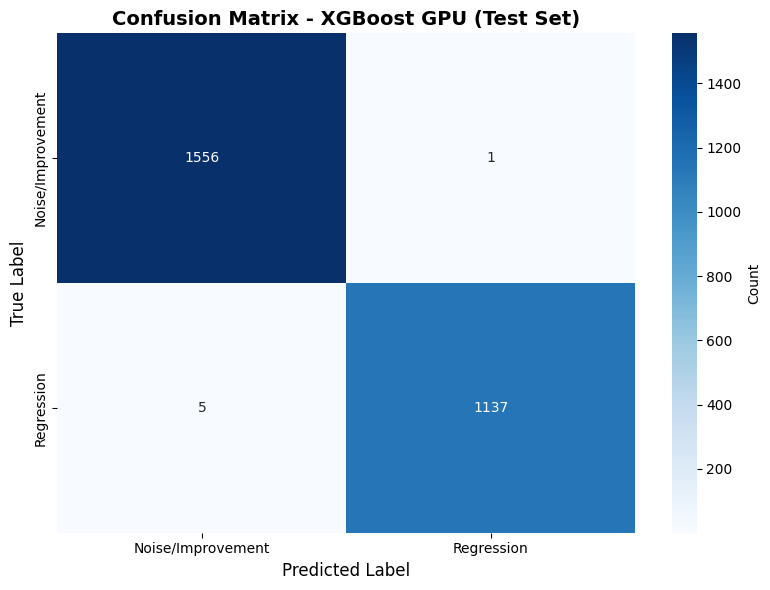


Confusion Matrix Breakdown:
  True Negatives (TN): 1556
  False Positives (FP): 1 - Noise alerts incorrectly flagged as regressions
  False Negatives (FN): 5 - True regressions missed by the model
  True Positives (TP): 1137

False Positive Rate: 0.06%
False Negative Rate: 0.44%


In [33]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Noise/Improvement', 'Regression'],
            yticklabels=['Noise/Improvement', 'Regression'],
            ax=ax, cbar_kws={'label': 'Count'})

ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title('Confusion Matrix - XGBoost GPU (Test Set)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN): {tn}")
print(f"  False Positives (FP): {fp} - Noise alerts incorrectly flagged as regressions")
print(f"  False Negatives (FN): {fn} - True regressions missed by the model")
print(f"  True Positives (TP): {tp}")
print(f"\nFalse Positive Rate: {fp/(fp+tn):.2%}")
print(f"False Negative Rate: {fn/(fn+tp):.2%}")

### 6.2 ROC Curve

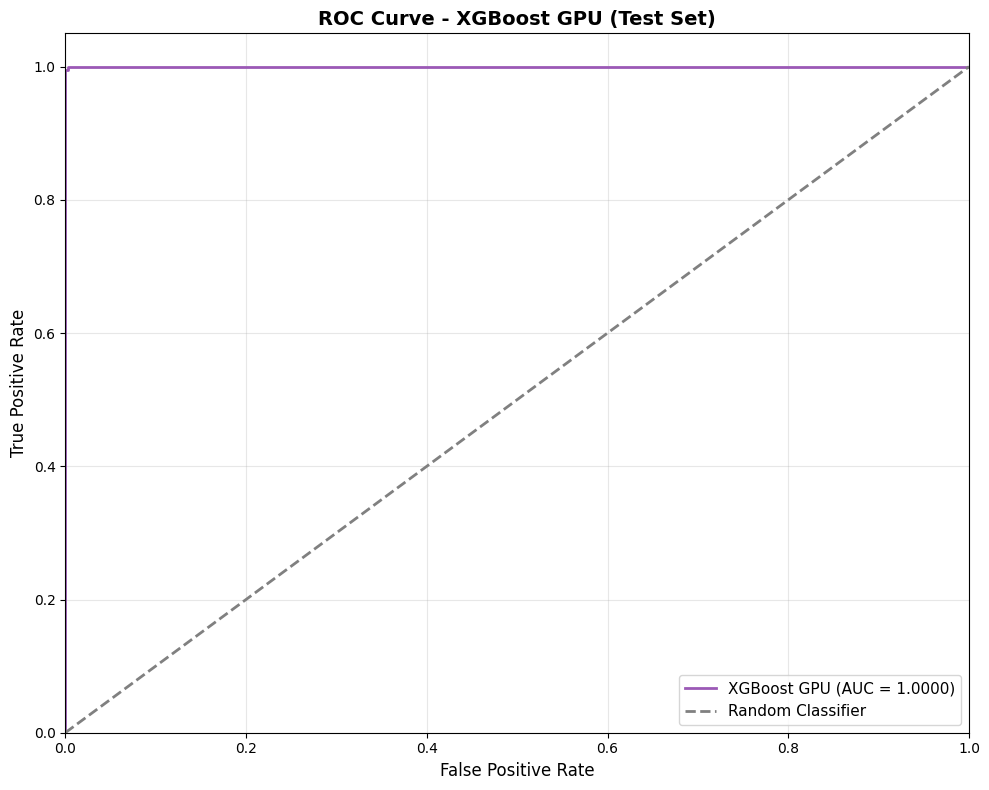

In [34]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr, tpr, color='#9b59b6', lw=2, label=f'XGBoost GPU (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - XGBoost GPU (Test Set)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.3 Feature Importance

Top 15 Most Important Features:


,Feature,Importance
1,single_alert_amount_abs,0.890191
13,"single_alert_series_signature_tags_fission, we...",0.054929
15,single_alert_series_signature_tags_webrender,0.019797
4,single_alert_new_value,0.009578
17,single_alert_series_signature_suite_freq,0.008314
3,alert_summary_status,0.004398
6,single_alert_status,0.003971
0,single_alert_amount_pct,0.003558
5,single_alert_prev_value,0.002559
2,single_alert_t_value,0.002557


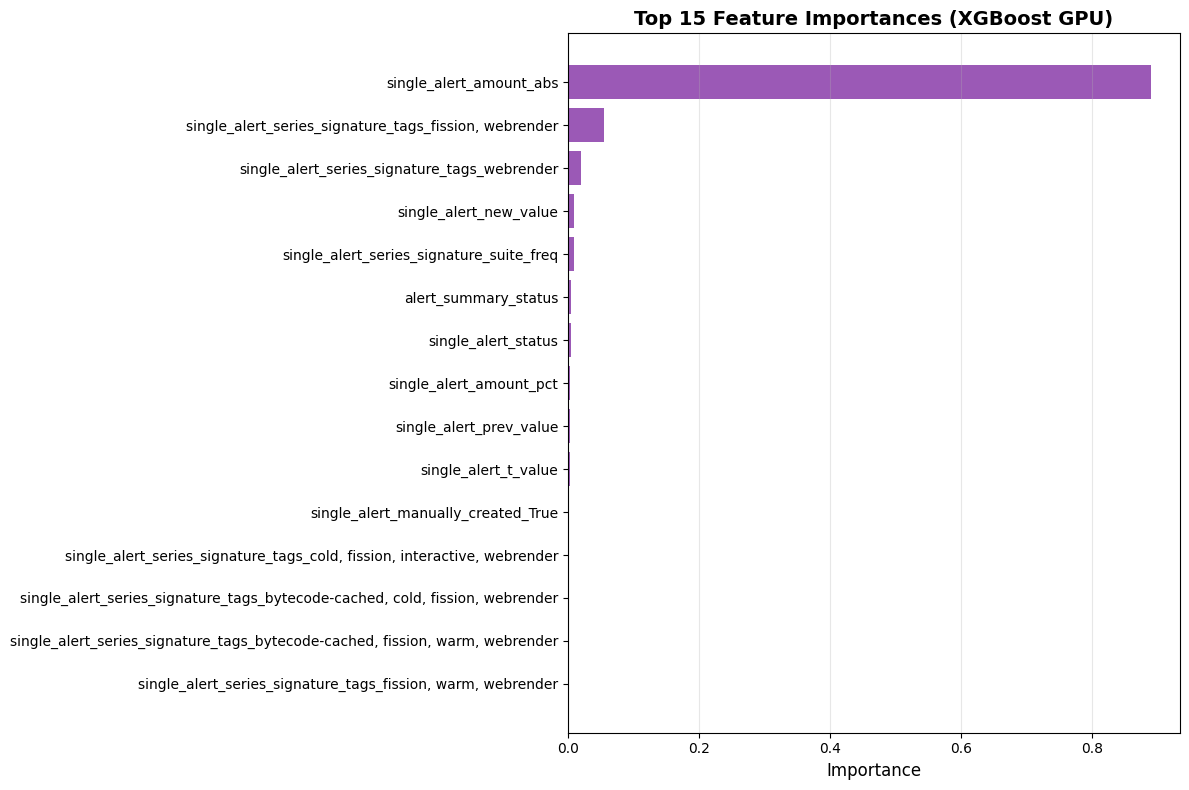

In [35]:
# Get feature importances from XGBoost
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 Most Important Features:")
display(feature_importance.head(15))

# Plot top 15 features
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['Importance'], color='#9b59b6')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Feature Importances (XGBoost GPU)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Model and Results

In [36]:
import pickle

# Save the best model
model_path = "../results/best_xgb_gpu_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(best_xgb_model, f)
print(f"Model saved to: {model_path}")

# Also save as XGBoost native format for better compatibility
xgb_native_path = "../results/best_xgb_gpu_model.json"
best_xgb_model.save_model(xgb_native_path)
print(f"Model also saved in XGBoost format to: {xgb_native_path}")

# Save feature importance
feature_importance_path = "../results/feature_importance_xgb.csv"
feature_importance.to_csv(feature_importance_path, index=False)
print(f"Feature importance saved to: {feature_importance_path}")

# Save model performance metrics
test_metrics = {
    'Model': 'XGBoost GPU',
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-Score': f1_score(y_test, y_test_pred),
    'ROC-AUC': roc_auc_score(y_test, y_test_proba)
}

metrics_df = pd.DataFrame([test_metrics])
metrics_path = "../results/model_performance_xgb.csv"
metrics_df.to_csv(metrics_path, index=False)
print(f"Performance metrics saved to: {metrics_path}")

Model saved to: ../results/best_xgb_gpu_model.pkl
Model also saved in XGBoost format to: ../results/best_xgb_gpu_model.json
Feature importance saved to: ../results/feature_importance_xgb.csv
Performance metrics saved to: ../results/model_performance_xgb.csv


## 8. Summary

### Model Training Complete! 🎉

**Final Model**: Tuned XGBoost Classifier with **GPU Acceleration** 🚀

**Key Achievements**:
1. ✅ Successfully split data (70/15/15) with stratification
2. ✅ Trained and compared 3 baseline models
3. ✅ Utilized GPU acceleration for XGBoost training
4. ✅ Performed hyperparameter tuning using GridSearchCV
5. ✅ Evaluated final model on held-out test set
6. ✅ Identified most important features for classification

**Outputs**:
- Trained model saved to `results/best_xgb_gpu_model.pkl`
- XGBoost native format saved to `results/best_xgb_gpu_model.json`
- Feature importance saved to `results/feature_importance_xgb.csv`
- Performance metrics saved to `results/model_performance_xgb.csv`

### Next Steps (Future Work):

**Experiment E2**: Cross-repository generalization
**Experiment E3**: Feature ablation studies
**Phase 2**: Time-series features and advanced detection models

In [ ]:
# Print final summary
print("="*70)
print("MODEL TRAINING SUMMARY - GPU ACCELERATED 🚀")
print("="*70)
print(f"\nBest Model: XGBoost with {best_xgb_model.n_estimators} trees (GPU)")
print(f"Hyperparameters: {xgb_grid.best_params_}")
print(f"\nTest Set Performance:")
for metric, value in list(test_metrics.items())[1:]:
    print(f"  {metric}: {value:.4f}")
print(f"\nTop 3 Most Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")
print("\n" + "="*70)
print("All results saved to ../results/ directory")
print("="*70)